In [1]:
# processing
import numpy as np
import pandas as pd
from Bio import SeqIO

# custom packages
import tregs

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 12})

from matplotlib import font_manager
font_manager.fontManager.addfont('../../misc/lucida-sans-unicode.ttf')

import seaborn as sns
tregs.mpl_pboc.plotting_style()

{'green': '#7AA974',
 'light_green': '#BFD598',
 'pale_green': '#DCECCB',
 'yellow': '#EAC264',
 'light_yellow': '#F3DAA9',
 'pale_yellow': '#FFEDCE',
 'blue': '#738FC1',
 'light_blue': '#A9BFE3',
 'pale_blue': '#C9D7EE',
 'red': '#D56C55',
 'light_red': '#E8B19D',
 'pale_red': '#F1D4C9',
 'purple': '#AB85AC',
 'light_purple': '#D4C2D9',
 'dark_green': '#7E9D90',
 'dark_brown': '#905426'}

It seems that experimental noise does lead to more noise in the information footprint. However, my hypothesis is that the level of noise has to be bigger than the bin size (so as to facilitate a sufficient number of bin transitions) in order to lead to noise.

### Loading input data

In [2]:
_genome = []
for record in SeqIO.parse("../../data/mg1655_genome.fasta", "fasta"):
    _genome.append(str(record.seq))
genome = _genome[0]

In [3]:
# Promoter
rnap_site = 'CAGGCTTTACACTTTATGCTTCCGGCTCGTATGTTGTGTGG'

# Operator sequence
rep_site = 'AATTGTGAGCGGATAACAATT'

## Find the transcription start site
df = pd.read_csv('../../data/ecoli_gene_list.csv')
lacZYA_TSS = int(df[(df.gene == 'lacZ') & (df.promoter == 'lacZp1')]['tss'].iloc[0])
promoter = tregs.seq_utils.get_regulatory_region(genome, lacZYA_TSS, reverse=True)

In [4]:
# obtained from https://journals.plos.org/ploscompbiol/article/figure?id=10.1371/journal.pcbi.1002811.g002

rnap_emat_raw = np.loadtxt('../../data/energy_matrices/RNAP_energy_matrix.txt')
rnap_emat = tregs.simulate.fix_wt(rnap_emat_raw, rnap_site)

In [5]:
O1_1027_raw = np.load('../../data/energy_matrices/lacThermoforTO1.npy')

O1_1027_fixed = np.zeros(np.shape(O1_1027_raw))
for i in range(3):
    O1_1027_fixed[i] = tregs.simulate.fix_wt(O1_1027_raw[i], rep_site)

rep_emat = np.mean(O1_1027_fixed, axis=0)

### Information footprint without noise for comparison

In [6]:
n_NS = len(genome)
n_p = 4600
n_r = 10

ep_wt = -5
er_wt = -15

df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                           ep_wt, er_wt, n_NS, n_p, n_r)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data,
                                                promoter, nbins, upper_bound,
                                                smoothed=True, windowsize=3)
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

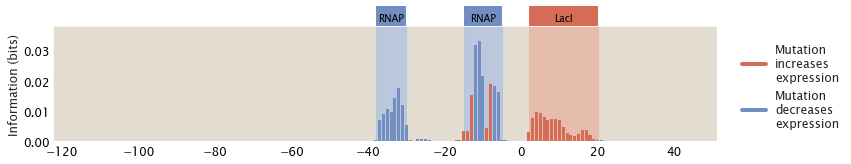

In [7]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/simrep_footprint.png', dpi=300, bbox_inches='tight')
plt.show()

### Simulating PCR

In [8]:
def amplify(seq_cnt, rounds, alpha=10, beta=1.5):
    num_seqs = len(seq_cnt)
    for round in range(rounds):
        amp_factor = 1 + np.random.beta(a=alpha, b=beta, size=num_seqs)
        seq_cnt = np.multiply(seq_cnt, amp_factor)
    scaling_factor = 10**(len(str(int(min(seq_cnt)))) - 1)
    return seq_cnt / scaling_factor

In [9]:
def simrep_with_pcr(wtseq, rnap_wtseq, rep_wtseq, rnap_emat, O1_emat, 
                    ep_wt, er_wt, n_NS, n_p, n_r,
                    num_mutants=1000,
                    rounds=20, alpha=10, beta=1.5):
    
    mutants = np.unique(tregs.wgregseq.mutations_rand(wtseq,
                                       rate=0.1,
                                       num_mutants=num_mutants,
                                       number_fixed=True))

    rnap_start, rnap_end = tregs.seq_utils.find_binding_site(wtseq, rnap_wtseq)
    rep_start, rep_end = tregs.seq_utils.find_binding_site(wtseq, rep_wtseq)

    df_simrep = tregs.simulate.simrep_helper(mutants, rnap_start, rnap_end, rep_start, rep_end,
                                             rnap_emat, O1_emat, n_p, n_r, n_NS,
                                             ep_wt, er_wt)
    
    dna_cnt = tregs.simulate.get_dna_cnt(len(df_simrep))
    df_simrep['ct_0'] = dna_cnt
    df_simrep = df_simrep[df_simrep.ct_0 != 0.0]

    df_simrep['ct_1_original'] = df_simrep['ct_0'] * df_simrep['pbound']
    rna_cnt = amplify(df_simrep['ct_1_original'].to_numpy(), rounds, alpha=alpha, beta=beta)
    df_simrep['ct_1'] = rna_cnt
    #df_simrep['ct_1'] = 1 + df_simrep['ct_1'].astype(int) # adding 1 as a pseudocount
    
    df_simrep['ct_0'] = df_simrep['ct_0'].astype(float)
    df_simrep['ct_1'] = df_simrep['ct_1'].astype(float)
    df_simrep['noise'] = (df_simrep['ct_1'].to_numpy() / np.min(df_simrep['ct_1'])) / (df_simrep['ct_1_original'].to_numpy() / np.min(df_simrep['ct_1_original']))
    df_simrep['norm_ct_1'] = df_simrep['ct_1'] / df_simrep['ct_0']

    return df_simrep

In [10]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

df = simrep_with_pcr(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                            ep_wt, er_wt, n_NS, n_p, n_r, rounds=30, alpha=3, beta=2)
n_seqs = len(df)
mut_list = df['seq'].values
mu_data = df['norm_ct_1']

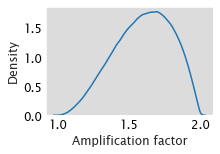

In [11]:
fig, ax = plt.subplots(figsize=(3, 2))
dist = np.random.beta(a=3, b=2, size=1000000)
sns.kdeplot(dist+1)
ax.set_xlabel('Amplification factor')
ax.set_facecolor("gainsboro")
plt.savefig('../../figs/beta_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

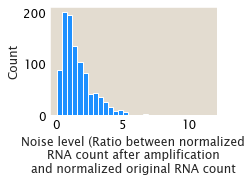

In [12]:
fig, ax = plt.subplots(figsize=(3,2))
ax.hist(df['noise'], bins=30, color='dodgerblue')
ax.set_xlabel('Noise level (Ratio between normalized\nRNA count after amplification\nand normalized original RNA count')
ax.set_ylabel('Count')
plt.show()

In [13]:
nbins = 2
upper_bound = np.mean(mu_data)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                               pseudocount=10**(-6))
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                    smoothed=True, windowsize=3)

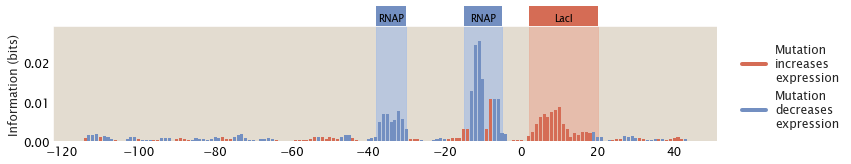

In [14]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

ax.set_ylim(top=max(footprint)*1.15)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/simrep_footprint_pcr_noise.png', dpi=300, bbox_inches='tight')
plt.show()

### Random sampling

In [15]:
def random_sampling(df, n=10**5):
    df_large = df.loc[df.index.repeat(df.ct_1)]
    print(len(df_large))
    print('There are {} copies of RNA in total'.format(np.sum(df['ct_1'])))
    
    df_random = df_large.sample(n=n).drop_duplicates()
    print('The current library size is {}'.format(len(df_random)))
    print('Library diversity decreaes by {:.1f}%'.format( (1 - len(df_random) / len(df)) * 100))
    return df_random

In [16]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

In [17]:
def get_footprint(n_NS, ep_wt, er_wt, n_p, n_r, sample_size=10**5):
    df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                            ep_wt, er_wt, n_NS, n_p, n_r, num_mutants=10000, scaling_factor=100)

    df_random = random_sampling(df, n=sample_size)
    mut_list = df_random['seq'].values
    mu_data = df_random['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)
    return footprint, exshift_list, mu_data

In [18]:
footprint, exshift_list, mu_data = get_footprint(n_NS, ep_wt, er_wt, n_p, n_r, sample_size=2000)

659752
There are 659752.0 copies of RNA in total
The current library size is 1447
Library diversity decreaes by 85.5%


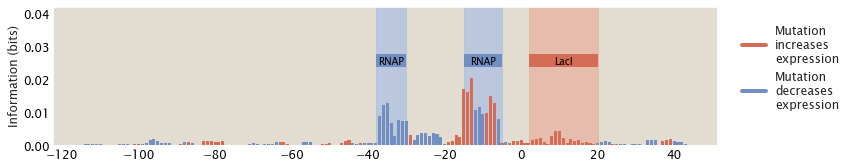

In [19]:
fig, ax = plt.subplots(figsize=(12,2.5))

ax.axvspan(-38, -30, alpha=0.7, color='#A9BFE3')
ax.axvspan(-15, -5, alpha=0.7, color='#A9BFE3')
ax.axvspan(2, 20, alpha=0.7, color='#E8B19D')

ax.set_ylim(top=0.042)
ax.add_patch(mpl.patches.Rectangle((-38, max(footprint)*1.15),
                                        8,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-38 + 0.5 * 8, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((-15, max(footprint)*1.15),
                                        10,
                                        max(footprint) * 0.2,
                                        facecolor='#738FC1',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(-15 + 0.5 * 10, max(footprint) * 1.2, 'RNAP', fontsize = 10, color = 'k',
         ha='center', va='baseline')

ax.add_patch(mpl.patches.Rectangle((2, max(footprint)*1.15),
                                        18,
                                        max(footprint) * 0.2,
                                        facecolor='#D56C55',
                                        clip_on=False,
                                        linewidth = 0))
ax.text(2 + 0.5 * 18, max(footprint) * 1.2, 'LacI', fontsize = 10, color = 'k',
         ha='center', va='baseline')


windowsize=3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('#D56C55' if exshift > 0 else '#738FC1') for exshift in exshift_list]
ax.bar(x, footprint, color=shiftcolors, edgecolor=None, linewidth=0)
ax.set_ylabel('Information (bits)', fontsize=12)

custom_lines = [Line2D([0], [0], color='#D56C55', lw=4),
                Line2D([0], [0], color='#738FC1', lw=4)]
plt.legend(custom_lines,
           ['Mutation\nincreases\nexpression', 'Mutation\ndecreases\nexpression'],
           bbox_to_anchor=(1.2, 0.95), frameon=False)

plt.tight_layout()
plt.savefig('../../figs/simrep_footprint_random_sampling.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
footprint, exshift_list, mu_data = get_footprint(n_NS, ep_wt, er_wt, n_p, n_r, sample_size=1000)

664448
There are 664448.0 copies of RNA in total
The current library size is 862
Library diversity decreaes by 91.4%


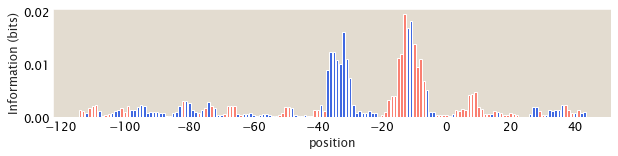

In [21]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
df = tregs.simulate.simrep(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                            ep_wt, er_wt, n_NS, n_p, n_r, num_mutants=832)

mut_list = df['seq'].values
mu_data2 = df['norm_ct_1']

nbins = 2
upper_bound = np.mean(mu_data2)
footprint = tregs.footprint.get_info_footprint(mut_list, mu_data2, promoter, nbins, upper_bound,
                                            pseudocount=10**(-6))
exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data2.values, promoter,
                                                    smoothed=True, windowsize=3)

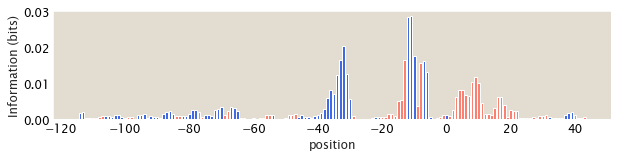

In [23]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

#plt.savefig('../figs/lacI_synthetic_footprint_5_15.png', dpi=300, bbox_inches='tight')
plt.show()

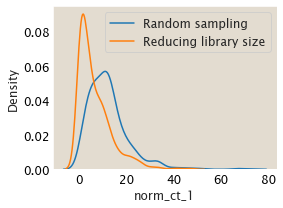

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
sns.kdeplot(mu_data, label='Random sampling')
sns.kdeplot(mu_data2, label='Reducing library size')
ax.legend()
plt.show()

## Combining PCR bias and random sampling

In [25]:
def get_footprint_with_experimental_noise(n_NS, ep_wt, er_wt, n_p, n_r, 
                                          rounds=20, alpha=10, beta=1.5, sample_size=10**5):
    df = simrep_with_pcr(promoter, rnap_site, rep_site, rnap_emat, rep_emat, 
                    ep_wt, er_wt, n_NS, n_p, n_r,
                    num_mutants=1000,
                    rounds=rounds, alpha=alpha, beta=beta)

    df_random = random_sampling(df, n=sample_size)
    mut_list = df_random['seq'].values
    mu_data = df_random['norm_ct_1']

    nbins = 2
    upper_bound = np.mean(mu_data)
    footprint = tregs.footprint.get_info_footprint(mut_list, mu_data, promoter, nbins, upper_bound,
                                                pseudocount=10**(-6))
    exshift_list = tregs.footprint.get_expression_shift(mut_list, mu_data.values, promoter,
                                                        smoothed=True, windowsize=3)
    return footprint, exshift_list, mu_data

In [26]:
n_NS = len(genome)
ep_wt, er_wt = -5, -15
n_p = 4600
n_r = 15

In [27]:
footprint, exshift_list, mu_data = get_footprint_with_experimental_noise(n_NS, ep_wt, er_wt, n_p, n_r,
                                                 rounds=10, sample_size=10000)

335978
There are 336477.9895646931 copies of RNA in total
The current library size is 771
Library diversity decreaes by 22.9%


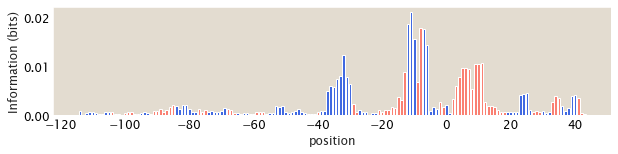

In [28]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()

In [29]:
footprint, exshift_list, mu_data = get_footprint_with_experimental_noise(n_NS, ep_wt, er_wt, n_p, n_r,
                                                                         rounds=30, sample_size=1000)

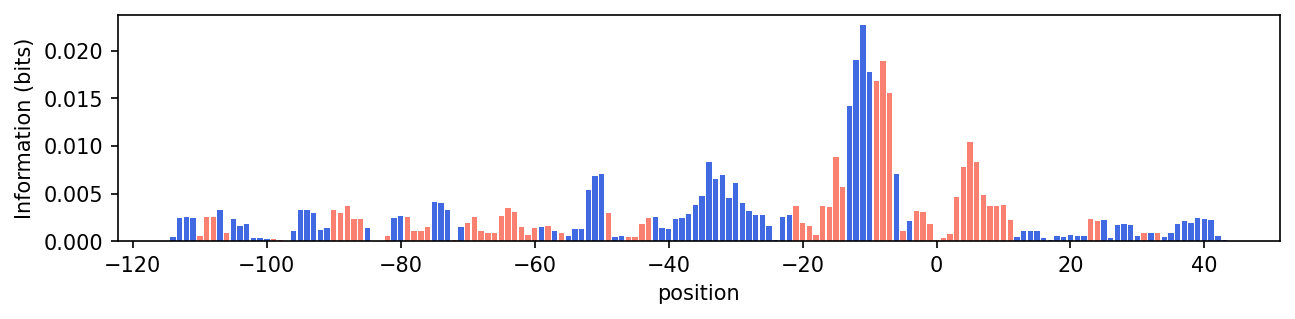

In [ ]:
fig, ax = plt.subplots(figsize=(10,2))
ax.set_ylabel('Information (bits)')
ax.set_xlabel('position')

windowsize = 3
cut = int((windowsize - 1) / 2)
x = np.arange(-115 + cut, 45 - cut)
shiftcolors = [('salmon' if exshift > 0 else 'royalblue') for exshift in exshift_list]
ax.bar(x, footprint, edgecolor=None, color=shiftcolors)

plt.show()